In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from keras_tuner import RandomSearch
import os
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

In [19]:
def crop_brain_contour(image, plot=False):
    # convert to gray
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    
    cnts = cv2.findContours(
        thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    
    
    if plot:
        plt.imshow(new_image)
    return new_image

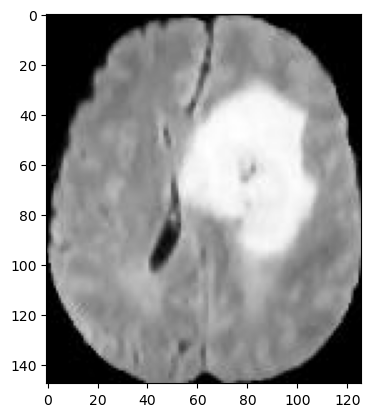

In [20]:
ex_img = cv2.imread('augmented data/yes/Image10.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [21]:
def load_data(dir_list, image_size):
    X = []
    y = []
    image_width, image_height = image_size
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(os.path.join(directory, filename))
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(
                image_width, image_height), interpolation=cv2.INTER_CUBIC)
            image = image / 255.0
            X.append(image)
            y.append([1] if directory[-3:] == 'yes' else [0])
    X = np.array(X)
    y = np.array(y)
    X, y = shuffle(X, y)
    return X, y

In [12]:
augmented_path = 'augmented data/'
augmented_yes = os.path.join(augmented_path, 'yes')
augmented_no = os.path.join(augmented_path, 'no')
IMG_WIDTH, IMG_HEIGHT = 240, 240
X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

In [25]:
X.shape

(3762, 240, 240, 3)

In [40]:
y.shape

(3762, 1)

In [26]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    for label in [0, 1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n / columns_n)

        plt.figure(figsize=(20, 10))

        i = 1  # current plot
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            # remove ticks
            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        def label_to_str(label): return "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

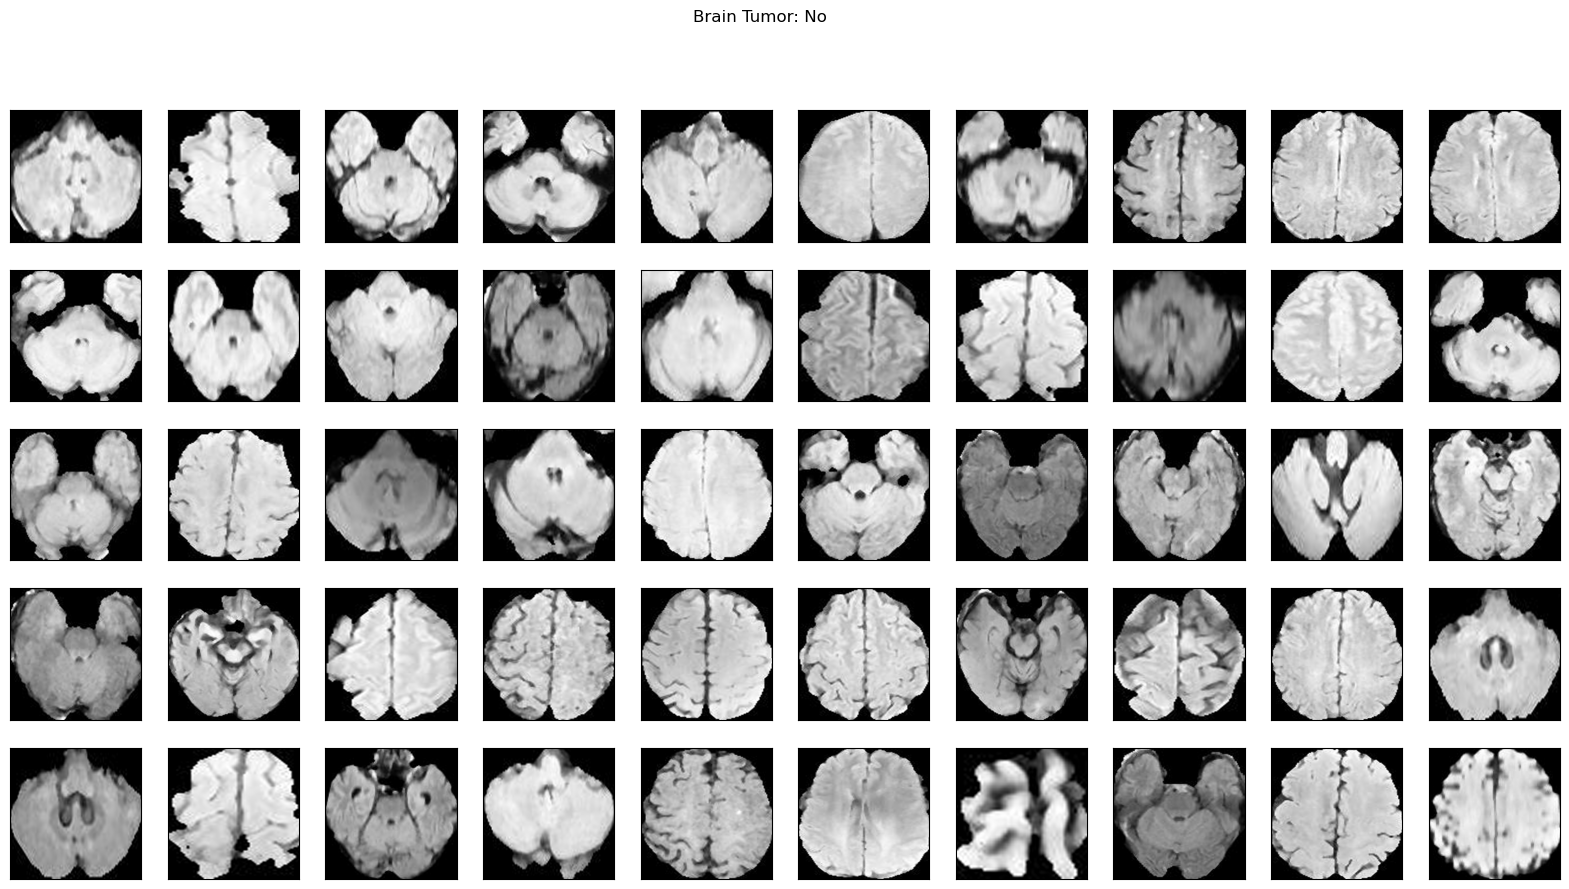

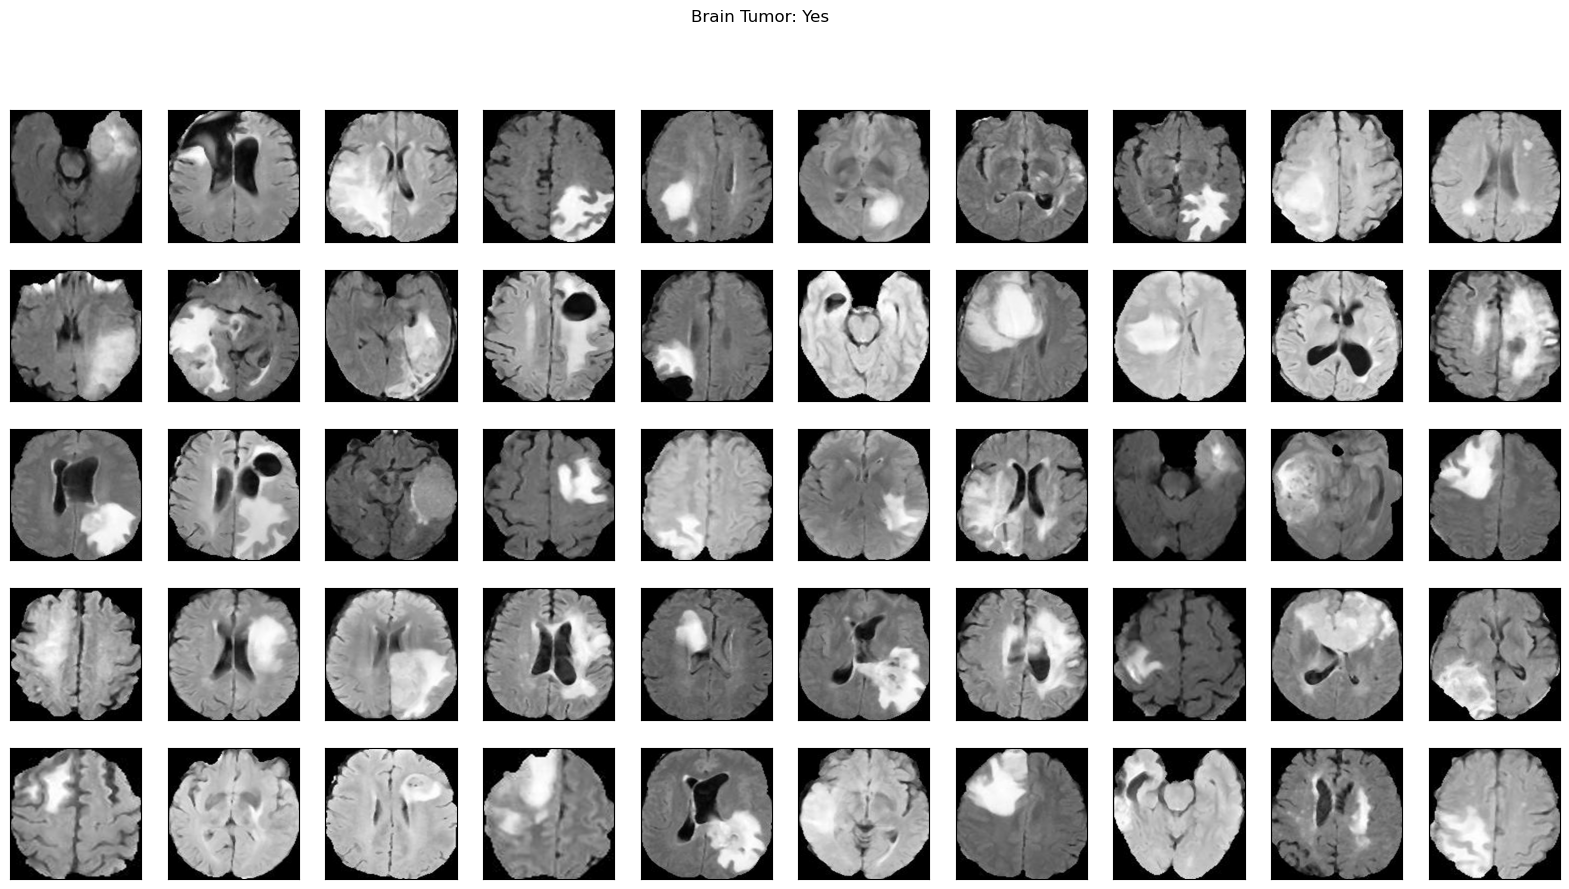

In [27]:
plot_sample_images(X, y)

In [28]:
def split_data(X, y, test_size=0.3):
    X_train, X_test_val, y_train, y_test_val = train_test_split(
        X, y, test_size=test_size, random_state=42)
    X_test, X_val, y_test, y_val = train_test_split(
        X_test_val, y_test_val, test_size=0.5, random_state=42)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [29]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(
    X, y, test_size=0.3)

In [30]:
print("number of training examples = " + str(X_train.shape[0]))
print("number of development examples = " + str(X_val.shape[0]))
print("number of test examples = " + str(X_test.shape[0]))
print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(y_train.shape))
print("X_val (dev) shape: " + str(X_val.shape))
print("Y_val (dev) shape: " + str(y_val.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_test shape: " + str(y_test.shape))


number of training examples = 2633
number of development examples = 565
number of test examples = 564
X_train shape: (2633, 240, 240, 3)
Y_train shape: (2633, 1)
X_val (dev) shape: (565, 240, 240, 3)
Y_val (dev) shape: (565, 1)
X_test shape: (564, 240, 240, 3)
Y_test shape: (564, 1)


In [31]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [32]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)

    score = f1_score(y_true, y_pred)

    return score

In [33]:
# Build the model with hyperparameter tuning
def build_model(hp):
    X_input = Input((240, 240, 3))
    X = ZeroPadding2D((2, 2))(X_input)
    X = Conv2D(hp.Int('conv_filters', min_value=32, max_value=128,
               step=16), (7, 7), strides=(1, 1), name='conv0')(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((4, 4), name='max_pool0')(X)
    X = MaxPooling2D((4, 4), name='max_pool1')(X)
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)
    model = Model(inputs=X_input, outputs=X, name='BrainDetectionModel')
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [34]:
tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=10,
                     executions_per_trial=1, directory='model_tuning', project_name='brain_tumor_detection')
tuner.search(x=X_train, y=y_train, epochs=10, validation_data=(X_val, y_val))

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# After hyperparameter tuning, use the best model for further training and evaluation
best_model.summary()

Trial 10 Complete [00h 20m 23s]
val_accuracy: 0.913274347782135

Best val_accuracy So Far: 0.9274336099624634
Total elapsed time: 05h 45m 51s


/Users/fightfei/anaconda3/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Model: "BrainDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 244, 244, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 238, 238, 80)   │        11,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 238, 238, 80)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 238, 238, 80)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool0 (MaxPooling2D)        │ (None, 59, 59, 80)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 14, 14, 80)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15680)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc (Dense)                      │ (None, 1)              │        15,681 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,841 (108.75 KB)

 Trainable params: 27,681 (108.13 KB)

 Non-trainable params: 160 (640.00 B)

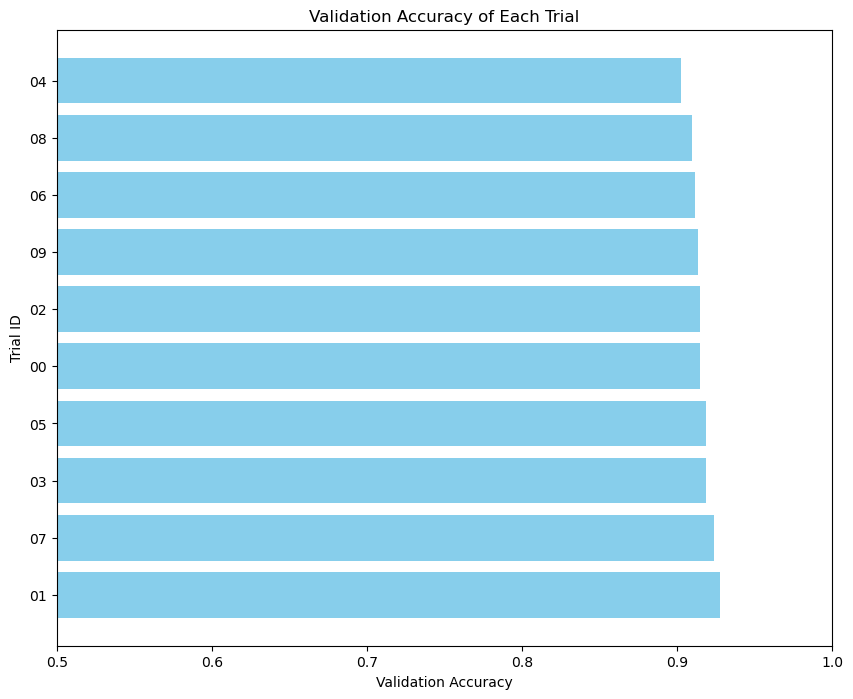

In [42]:
import matplotlib.pyplot as plt
import pandas as pd

completed_trials = tuner.oracle.get_best_trials(num_trials=10)

trial_ids = []
val_accuracies = []
hyperparameters = []

for trial in completed_trials:
    trial_ids.append(trial.trial_id)
    val_accuracies.append(trial.score) 
    hyperparameters.append(trial.hyperparameters.values)

df = pd.DataFrame({
    'Trial ID': trial_ids,
    'Validation Accuracy': val_accuracies,
    'Hyperparameters': hyperparameters
})

df.sort_values('Validation Accuracy', ascending=False, inplace=True)

plt.figure(figsize=(10, 8))
plt.barh(df['Trial ID'], df['Validation Accuracy'], color='skyblue')
plt.xlabel('Validation Accuracy')
plt.ylabel('Trial ID')
plt.title('Validation Accuracy of Each Trial')
plt.xlim([0.5, 1.0]) 
plt.show()


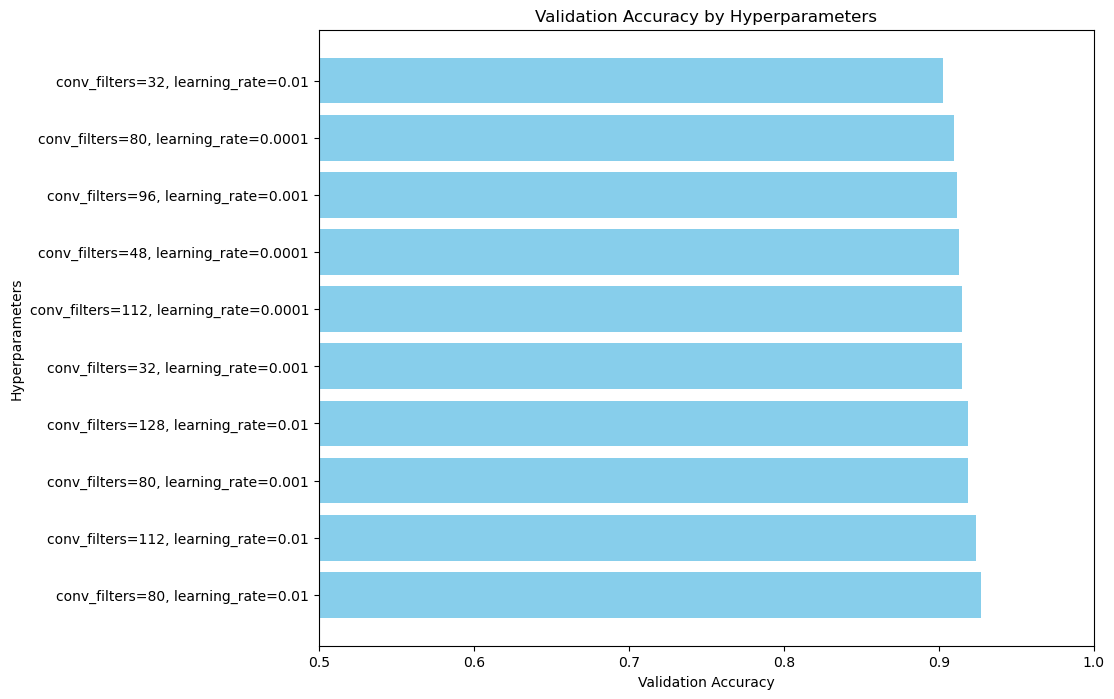

In [43]:
import matplotlib.pyplot as plt
import pandas as pd

completed_trials = tuner.oracle.get_best_trials(num_trials=10)

val_accuracies = []
hyperparameters_labels = []
# Extract data from each trial
for trial in completed_trials:
    hp_label = ', '.join([f"{key}={value}" for key, value in trial.hyperparameters.values.items()])
    hyperparameters_labels.append(hp_label)
    val_accuracies.append(trial.score) 

df = pd.DataFrame({
    'Hyperparameters': hyperparameters_labels,
    'Validation Accuracy': val_accuracies
})

df.sort_values('Validation Accuracy', ascending=False, inplace=True)

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(df['Hyperparameters'], df['Validation Accuracy'], color='skyblue')
plt.xlabel('Validation Accuracy')
plt.ylabel('Hyperparameters')
plt.title('Validation Accuracy by Hyperparameters')
plt.xlim([0.5, 1.0])  
plt.show()
